In [3]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 884.7/884.7 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 19.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 17.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.8/121.8 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 802.2/802.2 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.4/223.4 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.utils.callbacks import TFMProgressBar
from darts.models import NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score
from darts.datasets import EnergyDataset
from darts import concatenate

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)


def generate_torch_kwargs():
    # run torch models on CPU, and disable progress bars for all model stages except training.
    return {
        "pl_trainer_kwargs": {
            "accelerator": "cpu",
            "callbacks": [TFMProgressBar(enable_train_bar_only=True)],
        }
    }


In [5]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "R2: {}".format(r2_score(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [6]:
#importing the data
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [7]:
#checking the data availability
!ls "/content/drive/MyDrive/clear_sky_wms.csv"

/content/drive/MyDrive/clear_sky_wms.csv


In [8]:
# Load the CSV file into a Pandas DataFrame
multi_serie = pd.read_csv("/content/drive/MyDrive/clear_sky_wms.csv")
multi_serie

,planttimestring,inst_rain,poa,poa_dw,total_rain,ambTemp,cloud_cover,modTemp,humidity,ws
0,2023-12-10 00:00:00,0.0,0.0,1.174,0.0,12.309,1.068,6.512,52.233,0.983
1,2023-12-10 00:15:00,0.0,0.0,1.031,0.0,12.099,1.068,6.396,52.004,1.714
2,2023-12-10 00:30:00,0.0,0.0,1.366,0.0,12.232,1.603,6.581,51.810,2.065
3,2023-12-10 00:45:00,0.0,0.0,1.586,0.0,11.832,2.072,6.978,53.693,3.242
4,2023-12-10 01:00:00,0.0,0.0,1.519,0.0,12.242,2.072,7.111,52.242,2.827
...,...,...,...,...,...,...,...,...,...,...
2107,2023-12-31 22:45:00,0.0,0.0,0.746,0.0,11.496,0.096,8.466,70.113,2.776
2108,2023-12-31 23:00:00,0.0,0.0,0.770,0.0,11.362,0.096,8.336,71.174,2.743
2109,2023-12-31 23:15:00,0.0,0.0,0.779,0.0,11.162,0.096,7.874,72.206,2.519
2110,2023-12-31 23:30:00,0.0,0.0,0.748,0.0,10.771,0.744,7.476,74.291,2.553


In [9]:
multi_serie.dtypes

planttimestring     object
inst_rain          float64
poa                float64
poa_dw             float64
total_rain         float64
ambTemp            float64
cloud_cover        float64
modTemp            float64
humidity           float64
ws                 float64
dtype: object

In [10]:
multi_serie["planttimestring"]=pd.to_datetime(multi_serie["planttimestring"])
multi_serie.dtypes

planttimestring    datetime64[ns]
inst_rain                 float64
poa                       float64
poa_dw                    float64
total_rain                float64
ambTemp                   float64
cloud_cover               float64
modTemp                   float64
humidity                  float64
ws                        float64
dtype: object

Text(0.5, 1.0, 'poa')

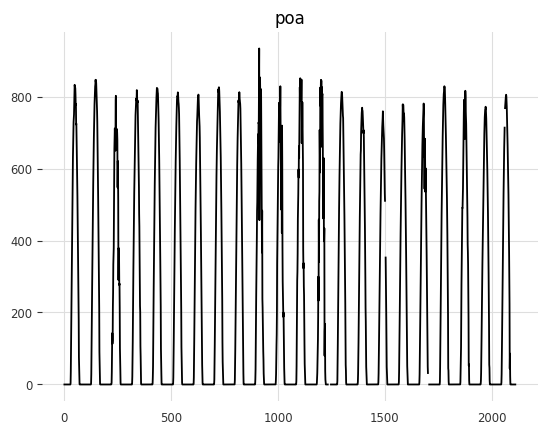

In [20]:
df = multi_serie
df["poa"].plot()
plt.title("poa")

Text(0.5, 1.0, 'poa')

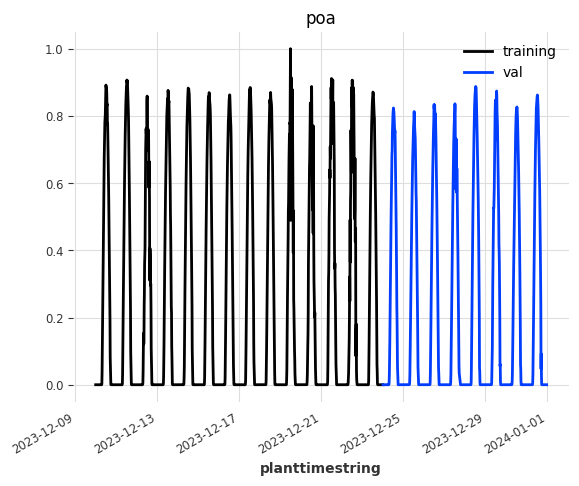

In [43]:
df_day_avg = df.groupby(df.index.astype(str).str.split(" ").str[0]).mean().reset_index()
filler = MissingValuesFiller()
scaler = Scaler()
series = filler.transform(
    TimeSeries.from_dataframe(
        df_day_avg, "planttimestring", ["poa"]
    )
).astype(np.float32)

train, val = series.split_after(pd.Timestamp("20231224"))  #we are pedicting from the day "2023-12-17"

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)


train_scaled.plot(label="training")
val_scaled.plot(label="val")
plt.title("poa")

In [44]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [45]:

model_nbeats.fit(train_scaled, val_series=val_scaled)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=10, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=100, nr_epochs_val_period=1, batch_size=800, random_state=42, model_name=nbeats_run, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7c4ea93b4e50>]})

In [46]:
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [47]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=val.start_time(),
    forecast_horizon=7,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

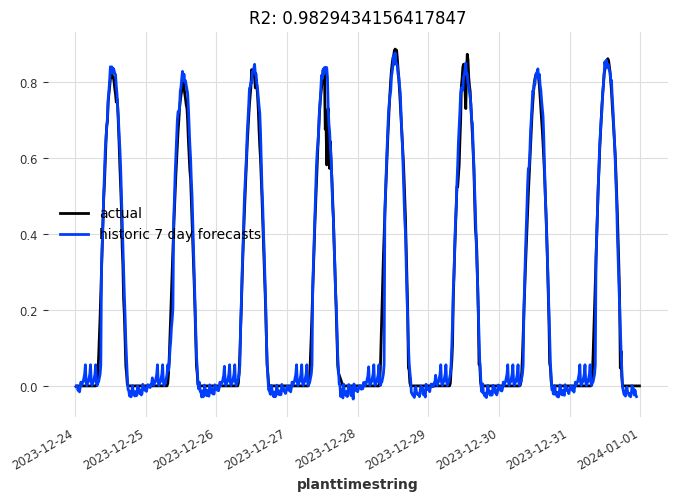

In [48]:
display_forecast(
    pred_series,
    series_scaled,
    "7 day",
    start_date=val.start_time(),
)

Text(0.5, 1.0, 'ambTemp')

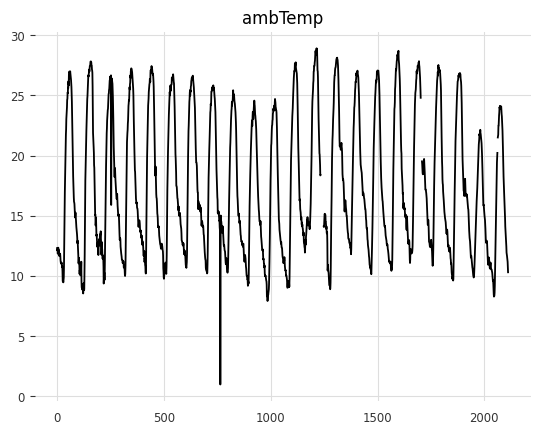

In [32]:
#now let us do the same for ambient temperature
df = multi_serie
df["ambTemp"].plot()
plt.title("ambTemp")

Text(0.5, 1.0, 'ambTemp')

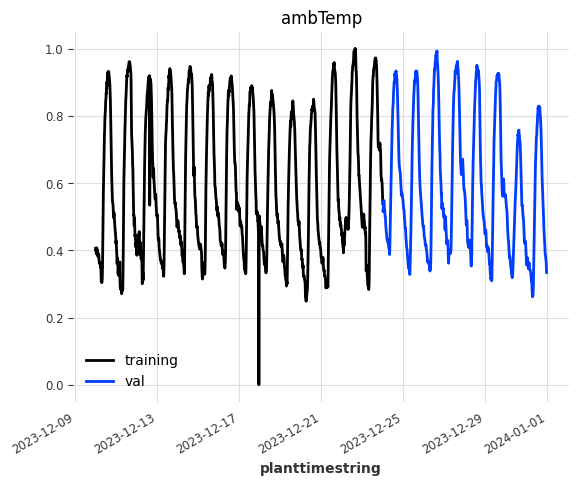

In [38]:
df_day_avg = df.groupby(df.index.astype(str).str.split(" ").str[0]).mean().reset_index()
filler = MissingValuesFiller()
scaler = Scaler()
series = filler.transform(
    TimeSeries.from_dataframe(
        df_day_avg, "planttimestring", ["ambTemp"]
    )
).astype(np.float32)

train, val = series.split_after(pd.Timestamp("20231224"))  #we are pedicting from the day "2023-12-17"

train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series)


train_scaled.plot(label="training")
val_scaled.plot(label="val")
plt.title("ambTemp")

In [39]:
model_name = "nbeats_run"
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=True,
    num_stacks=10,
    num_blocks=1,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [40]:
model_nbeats.fit(train_scaled, val_series=val_scaled)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=True, num_stacks=10, num_blocks=1, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=100, nr_epochs_val_period=1, batch_size=800, random_state=42, model_name=nbeats_run, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7c4ea8e25e40>]})

In [41]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=val.start_time(),
    forecast_horizon=7,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

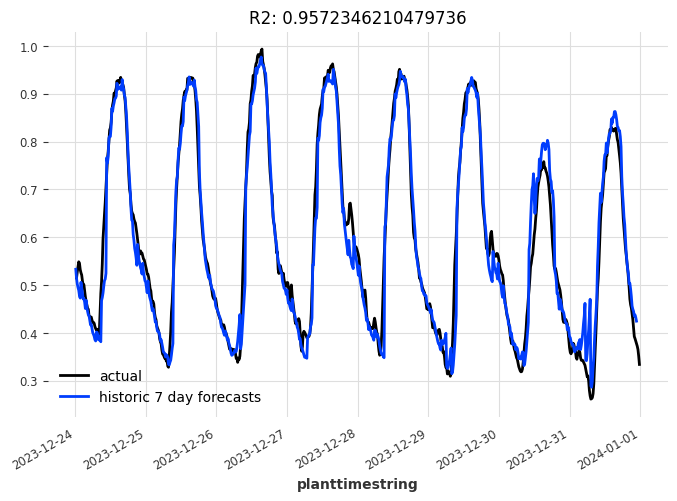

In [42]:
display_forecast(
    pred_series,
    series_scaled,
    "7 day",
    start_date=val.start_time(),
)

In [49]:
#now let us try to build an interpretable model
model_name = "nbeats_interpretable_run"
model_nbeats = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    generic_architecture=False,
    num_blocks=3,
    num_layers=4,
    layer_widths=512,
    n_epochs=100,
    nr_epochs_val_period=1,
    batch_size=800,
    random_state=42,
    model_name=model_name,
    save_checkpoints=True,
    force_reset=True,
    **generate_torch_kwargs(),
)

In [50]:
model_nbeats.fit(series=train_scaled, val_series=val_scaled)

Training: 0it [00:00, ?it/s]

NBEATSModel(output_chunk_shift=0, generic_architecture=False, num_stacks=30, num_blocks=3, num_layers=4, layer_widths=512, expansion_coefficient_dim=5, trend_polynomial_degree=2, dropout=0.0, activation=ReLU, input_chunk_length=30, output_chunk_length=7, n_epochs=100, nr_epochs_val_period=1, batch_size=800, random_state=42, model_name=nbeats_interpretable_run, save_checkpoints=True, force_reset=True, pl_trainer_kwargs={'accelerator': 'cpu', 'callbacks': [<darts.utils.callbacks.TFMProgressBar object at 0x7c4eb1c9ebc0>]})

In [51]:
model_nbeats = NBEATSModel.load_from_checkpoint(model_name=model_name, best=True)

In [52]:
pred_series = model_nbeats.historical_forecasts(
    series_scaled,
    start=val_scaled.start_time(),
    forecast_horizon=7,
    stride=7,
    last_points_only=False,
    retrain=False,
    verbose=True,
)
pred_series = concatenate(pred_series)

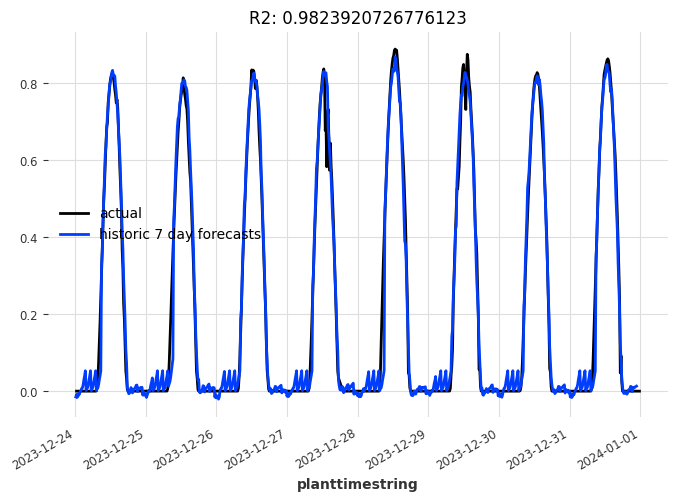

In [53]:

display_forecast(
    pred_series, series_scaled, "7 day", start_date=val_scaled.start_time()
)